C:\Users\15261\AppData\Local\Temp\ipykernel_7268\4000959314.py:46: RuntimeWarning: divide by zero encountered in double_scalars
  H_BHPF[u, v] = 1 / (1 + (D0 / D[u, v]) ** (2 * n))


[[112  36  35 ...  31  28  29]
 [110  31  29 ...  38  35  37]
 [111  33  29 ...  33  31  33]
 ...
 [110  28  28 ...  28  28  28]
 [114  68  68 ...  68  64  64]
 [158 155 156 ... 156 155 155]]
[[ 90.73998495  34.54000484  49.59834965 ...  45.45647801  35.09045417
   27.03219807]
 [ 92.02414242  17.09443972  41.6630254  ...  55.08729673  48.99708778
   48.3425211 ]
 [117.97525131  48.06413436  45.13209861 ...   7.43509377  26.00507038
   51.85311099]
 ...
 [120.59452767  61.51571599  66.5619459  ...  18.31947368  30.36084129
   41.55694733]
 [121.51379137  92.6454259   99.90661341 ...  44.99694963  57.03328797
   75.14898804]
 [162.87870744 167.09578455 176.18287669 ... 122.65951679 140.59550557
  168.4157507 ]]
[[3.81565151e-04 2.23838483e-03 1.88461775e-02 ... 1.27935834e-01
  3.61760884e-02 3.83131673e-03]
 [8.36224414e-03 5.08957814e-02 2.98074785e-01 ... 3.01681073e-01
  8.96389469e-02 1.57590114e-02]
 [8.12527748e-02 5.18777577e-01 1.00000000e+00 ... 7.56875740e-01
  2.51210617e-01

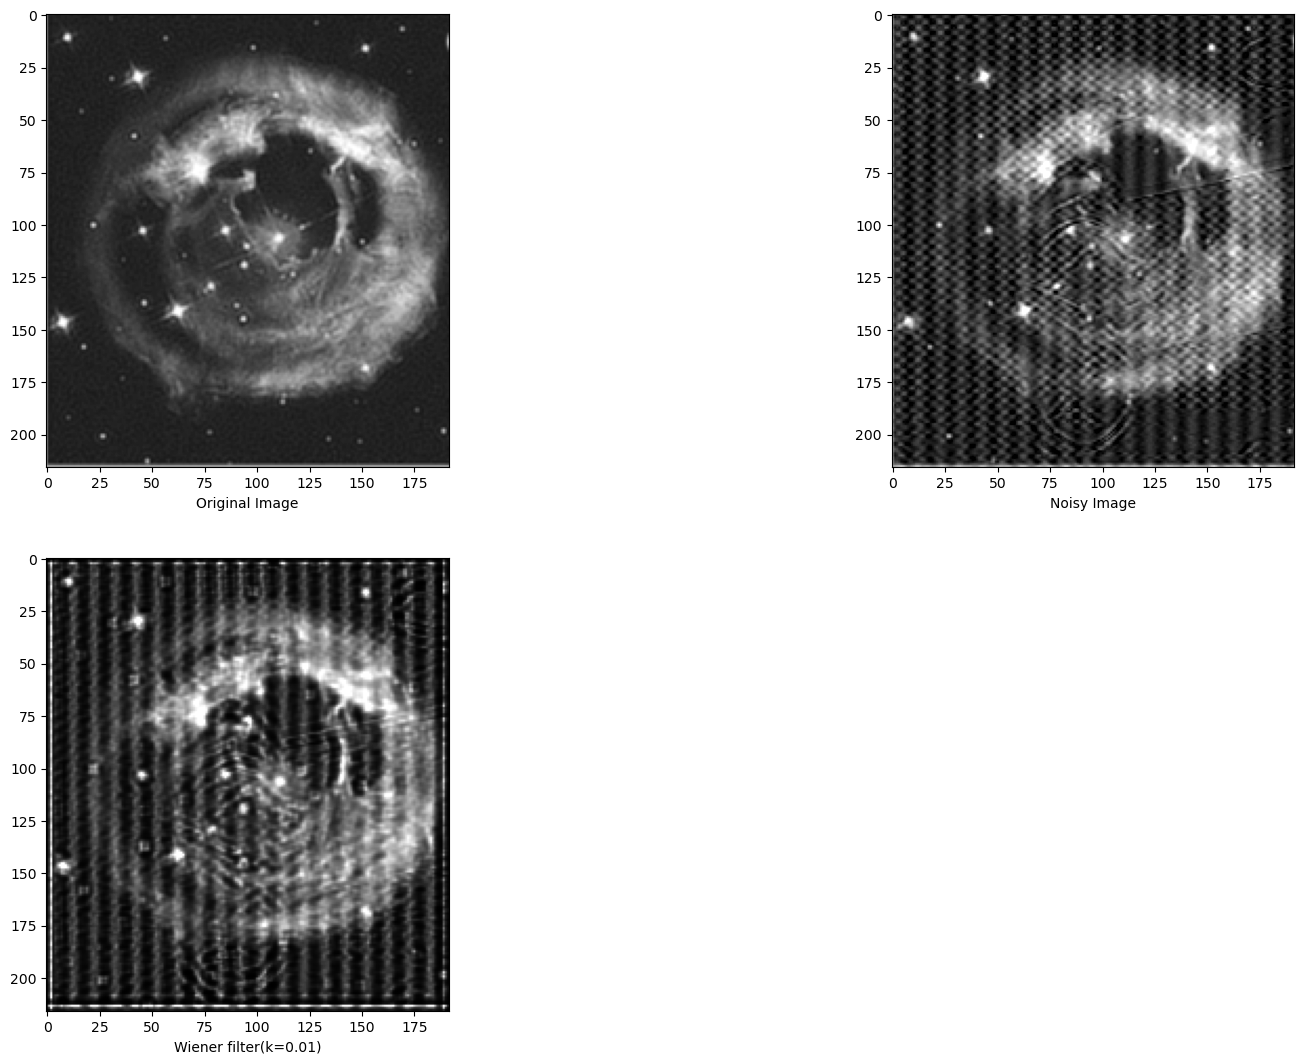

22.769175690751993
0.3655455040175553


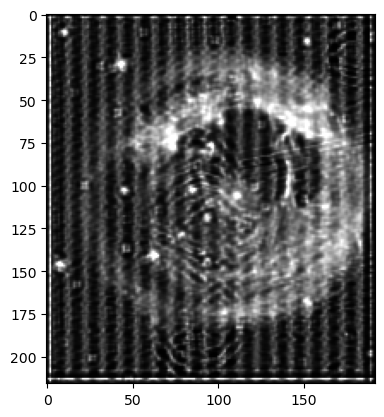

22.5485273524535
0.3549151038543345


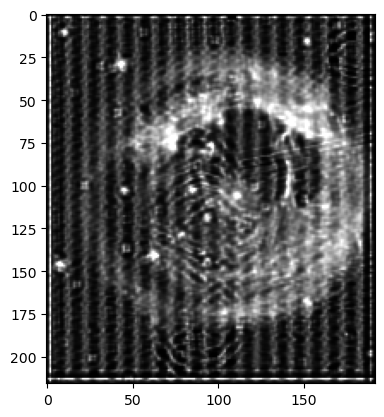

22.349351052913626
0.3447780635185401


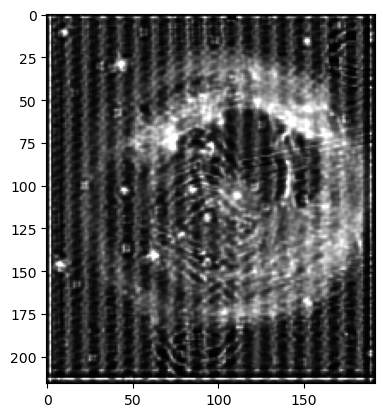

22.168181203994763
0.335081863912094


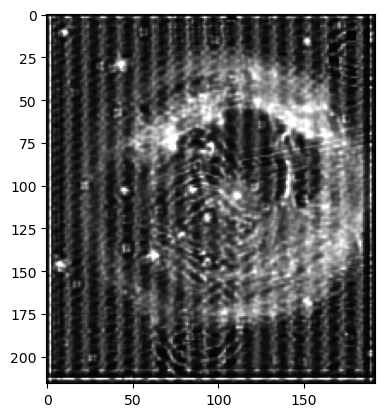

21.999322891688404
0.32577943914343677


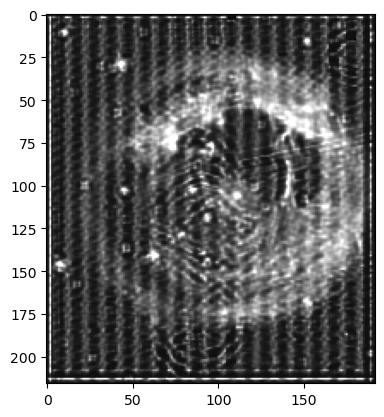

21.84116025092422
0.3168490551560394


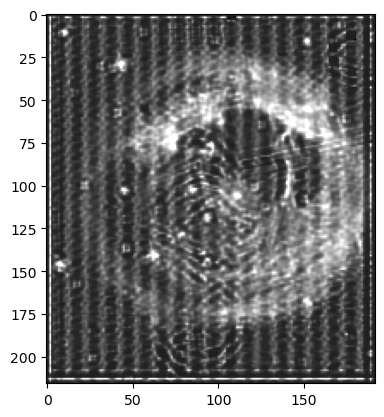

21.69038522914942
0.3082747601376414


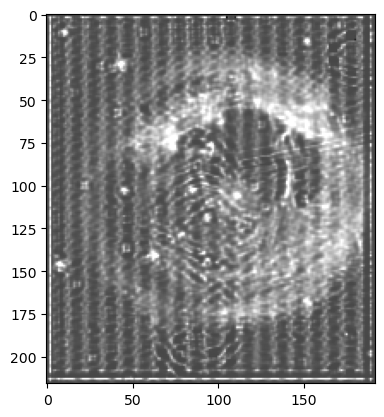

21.545904236539442
0.3000548884636199


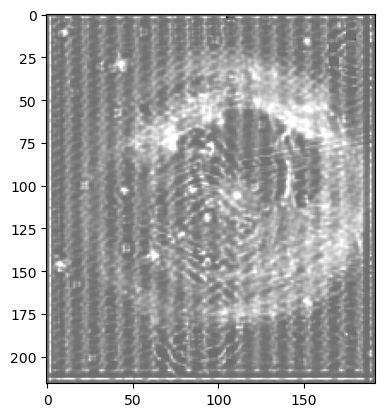

21.406954212233305
0.2921678691838587


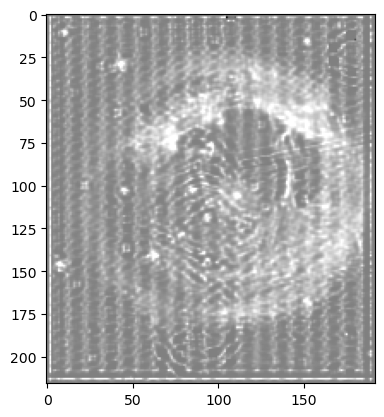

In [4]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import fft
from skimage import color, data, restoration, filters
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from matplotlib.colors import LogNorm


def add_periodic_noise(img, mean, amplitude, frequency):
    rows, cols = img.shape 
    noise = np.zeros((rows, cols)) 
    for i in range(rows):
        for j in range(cols):
            noise[i, j] = mean + amplitude * np.sin(2 * np.pi * frequency * j)
    return img + noise

def get_img_fft_shift(img):
    img_fft = np.fft.fft2(img)
    img_fft_shift = np.fft.fftshift(img_fft)
    return img_fft_shift

def notchFilter(img, n, UV_set):  # n is the parameter of the Butterworth highpass filter
    # Q is the number of Butterworth highpass filter pairs
    M, N = img.shape
    # initialize the filter
    H_notch = np.zeros((M, N))
    length_set = len(UV_set)
    for i in range(length_set):
        uk, vk, D0 = UV_set[i]
        if i == 0:
            H_notch = BHPF(M, N, D0, n, uk, vk) * BHPF(M, N, D0, n, -uk, -vk)
        else:
            H_notch = H_notch * BHPF(M, N, D0, n, uk, vk) * BHPF(M, N, D0, n, -uk, -vk)
    return H_notch

def BHPF(M, N, D0, n, uk, vk):
    H_BHPF = np.zeros((M, N))
    D = np.zeros((M, N))
    for u in range(M):
        for v in range(N):
            D[u, v] = np.sqrt((u - M / 2 - uk) ** 2 + (
                    v - N / 2 - vk) ** 2)  # euclidean distance from (u,v) to ((uk,vk) related to center)
            H_BHPF[u, v] = 1 / (1 + (D0 / D[u, v]) ** (2 * n))
    return H_BHPF


img_name_1="astronomy_img_1.png"
Img_astronomy_1=cv2.imread("./images/"+img_name_1, cv2.IMREAD_GRAYSCALE)
Img_astronomy_1_fft_shift=get_img_fft_shift(Img_astronomy_1)

# img_name_2="astronomy_img_mercury.jpg"
# Img_astronomy_2=cv2.imread("./../images/"+img_name_2, cv2.IMREAD_GRAYSCALE)
# Img_astronomy_2_fft_shift=get_img_fft_shift(Img_astronomy_2)
# show_DFT_magnitude(Img_astronomy_2_fft_shift,"discrete fourier transform magnitude of the second image")

# read the newspaper image
img_newspaper_name="car_newsprint.tif"
Img_newspaper=cv2.imread("./images/"+img_newspaper_name, cv2.IMREAD_GRAYSCALE)
Img_newspaper=cv2.resize(Img_newspaper,dsize=(192,216),interpolation=cv2.INTER_LINEAR)
Img_newspaper_fft_shift = get_img_fft_shift(Img_newspaper)

n=4
UV_set_newspaper=[(42, -28, 20), (84, -28, 20), (-42, -28, 20), (-84, -28, 20)]
# get the notch pass filter
Img_newspaper_notch_pass=1-notchFilter(Img_newspaper,n,UV_set_newspaper)
# add the Moire pattern
Img_astronomy_1_fft_shift_added=Img_astronomy_1_fft_shift+Img_newspaper_notch_pass*Img_newspaper_fft_shift
# use the inverse fourier transformation to view the image after the addition of the Moire pattern
def img_ifft(img_fft_shift): 
    Img_inverse_fft_shift = np.fft.ifftshift(img_fft_shift)
    Img_inverse_fft=np.fft.ifft2(Img_inverse_fft_shift)
    Img_inverse_fft=np.abs(Img_inverse_fft)
    return Img_inverse_fft


Img_astronomy_1_added_Moire=img_ifft(Img_astronomy_1_fft_shift_added)
noisy = add_periodic_noise(Img_astronomy_1_added_Moire, 0, 20, 0.1)+np.random.normal(0, 2, Img_astronomy_1_added_Moire.shape)


image = Img_astronomy_1
img_h = image.shape[0]
img_w = image.shape[1]
PSF = np.ones((5, 5)) / 25



plt.figure(figsize=(20, 20))

plt.subplot(321)
plt.xlabel("Original Image")
plt.imshow(image, cmap='gray', vmin=0, vmax=255)

plt.subplot(322)
plt.xlabel("Noisy Image")
plt.imshow(noisy, cmap='gray', vmin=0, vmax=255)

rl_result = restoration.richardson_lucy(noisy/255, PSF, num_iter=10)  # Wiener filter
plt.subplot(323)
plt.xlabel("Wiener filter(k=0.01)")
plt.imshow(rl_result, cmap='gray')

print(image)
print(noisy)
print(rl_result)

for i in range(10):
    rl_result = restoration.richardson_lucy(noisy/255, PSF, num_iter=10+i)
    plt.imshow(rl_result, cmap='gray')
    psnr5 = psnr(rl_result, image/255)
    ssim5 = ssim(rl_result, image/255)
    print(psnr5)
    print(ssim5)
    plt.show()
    

